# Capstone Project Model Test (LSTM)

## Library & Utility

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from google.colab import files
import matplotlib.dates as mdates
import csv

%matplotlib inline

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Data Preparation

In [3]:
data = files.upload()

Saving dataset.csv to dataset (4).csv


In [4]:
data_df = pd.read_csv('/content/dataset.csv')
data_df

,TANGGAL,JENIS,QTY,HARGA,JUMLAH
0,5/8/2023,CRMTT,"1,000.00","23,000.00","23,000,000.00"
1,5/10/2023,CRMTT,958.00,"23,000.00","22,034,000.00"
2,5/11/2023,CRMTT,"1,042.00","23,000.00","23,966,000.00"
3,5/11/2023,CRMTT,508.00,"30,000.00","15,240,000.00"
4,5/13/2023,CRMTT,"1,291.00","30,000.00","38,730,000.00"
...,...,...,...,...,...
205,5/13/2024,CRMTT,"1,612.00","19,000.00","30,628,000.00"
206,5/14/2024,CRMTT,"1,600.00","19,000.00","30,400,000.00"
207,5/15/2024,CRMTT,303.00,"19,000.00","5,757,000.00"
208,5/15/2024,CRMTT,769.00,"25,000.00","19,225,000.00"


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TANGGAL  210 non-null    object
 1   JENIS    210 non-null    object
 2   QTY      210 non-null    object
 3   HARGA    210 non-null    object
 4   JUMLAH   210 non-null    object
dtypes: object(5)
memory usage: 8.3+ KB


In [6]:
# Copy dataframe
df_copy = data_df.copy()

# Convert tipe data
df_copy['QTY'] = df_copy['QTY'].str.strip().str.replace(',', '').astype(float)
df_copy['HARGA'] = df_copy['HARGA'].str.strip().str.replace(',', '').astype(float)
df_copy['JUMLAH'] = df_copy['JUMLAH'].str.strip().str.replace(',', '').astype(float)
df_copy['TANGGAL'] = pd.to_datetime(df_copy['TANGGAL'], format='mixed')
df_copy.set_index('TANGGAL', inplace=True)

In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210 entries, 2023-05-08 to 2024-05-18
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   JENIS   210 non-null    object 
 1   QTY     210 non-null    float64
 2   HARGA   210 non-null    float64
 3   JUMLAH  210 non-null    float64
dtypes: float64(3), object(1)
memory usage: 8.2+ KB


In [8]:
df_copy

,JENIS,QTY,HARGA,JUMLAH
TANGGAL,,,,
2023-05-08,CRMTT,1000.0,23000.0,23000000.0
2023-05-10,CRMTT,958.0,23000.0,22034000.0
2023-05-11,CRMTT,1042.0,23000.0,23966000.0
2023-05-11,CRMTT,508.0,30000.0,15240000.0
2023-05-13,CRMTT,1291.0,30000.0,38730000.0
...,...,...,...,...
2024-05-13,CRMTT,1612.0,19000.0,30628000.0
2024-05-14,CRMTT,1600.0,19000.0,30400000.0
2024-05-15,CRMTT,303.0,19000.0,5757000.0


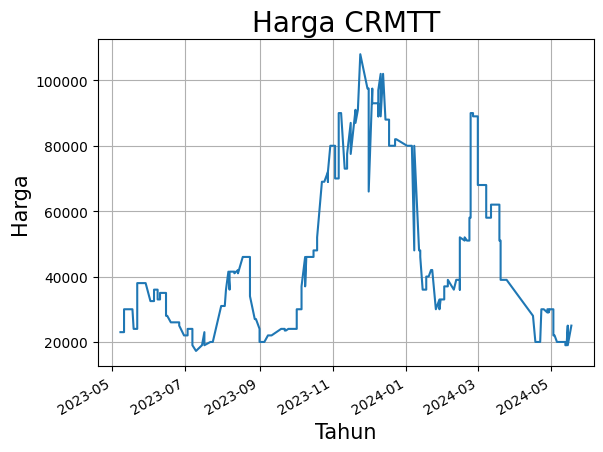

In [9]:
# Plot price
df_copy['HARGA'].plot(grid = True)
plt.title("Harga CRMTT", color = 'black', fontsize = 20)
plt.xlabel('Tahun', color = 'black', fontsize = 15)
plt.ylabel('Harga', color = 'black', fontsize = 15)
plt.show()

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.map(lambda window: (window[:-1], window[-1]))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [11]:
window_size = 10
batch_size = 32
shuffle_buffer = len(df_copy)

# Normalizes the data
data_harga = df_copy[['HARGA']].values
dates = df_copy.index.values
split_time = int(len(data_harga) * 0.8)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(data_harga)
data_harga = scaler.transform(data_harga)

# Splits the data into training and validation sets
x_train = data_harga[:split_time]
x_valid = data_harga[split_time:]

# Split the dates into training and validation sets
dates_train = dates[:split_time]
dates_valid = dates[split_time:]

# Window the data_harga
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer)

## Training

In [53]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(filters=64, kernel_size=3,
#                          strides=1, activation="relu",
#                          padding='causal', input_shape=[None, 1]),
#   tf.keras.layers.LSTM(64, return_sequences=True),
#   tf.keras.layers.LSTM(64),
#   tf.keras.layers.Dense(30, activation="relu"),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10, activation="relu"),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(1),
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = [None, 1], activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, activation="tanh"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

history = model.fit(train_set, epochs=500, validation_data=valid_set)

Epoch 1/500
5/5 [==============================] - 11s 684ms/step - loss: 0.0761 - mae: 0.3035 - val_loss: 0.0048 - val_mae: 0.0768
Epoch 2/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0277 - mae: 0.1901 - val_loss: 0.0590 - val_mae: 0.3315
Epoch 3/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0216 - mae: 0.1670 - val_loss: 0.0132 - val_mae: 0.1453
Epoch 4/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0233 - mae: 0.1734 - val_loss: 0.0087 - val_mae: 0.1104
Epoch 5/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0179 - mae: 0.1497 - val_loss: 0.0245 - val_mae: 0.2044
Epoch 6/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0150 - mae: 0.1397 - val_loss: 0.0261 - val_mae: 0.2087
Epoch 7/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0137 - mae: 0.1315 - val_loss: 0.0126 - val_mae: 0.1354
Epoch 8/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0148 - mae: 0.

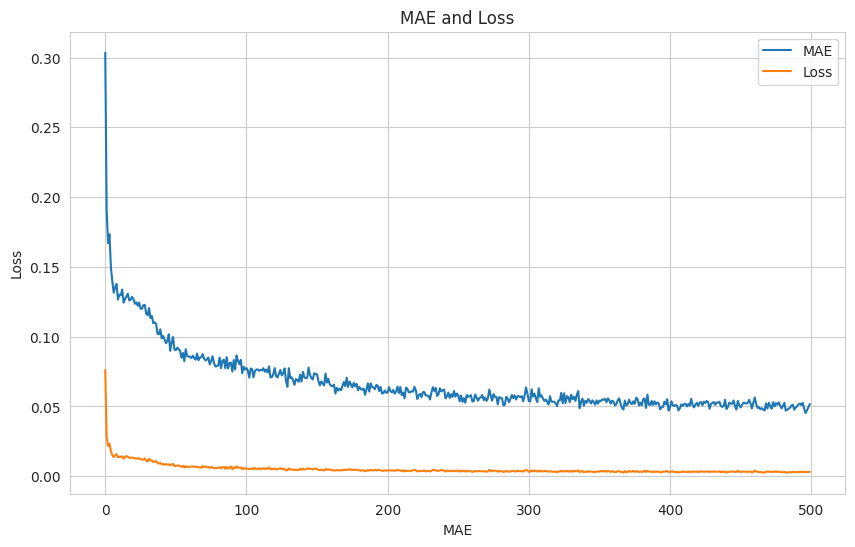

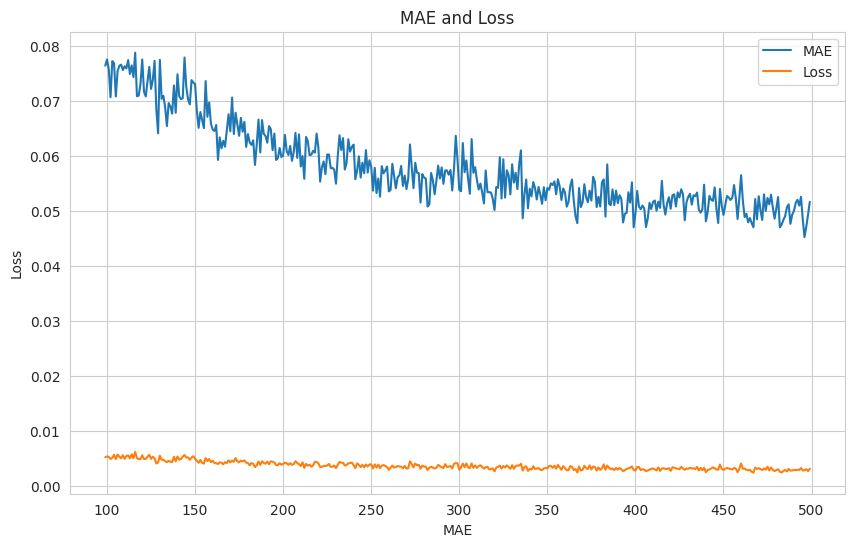

In [54]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Validation

In [55]:
# Print the shape of x_valid before reshaping
print("Shape of x_valid before reshaping:", x_valid.shape)

# Reshape x_valid sesuai dengan kebutuhan model
x_valid_reshaped = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))

# Print the shape of x_valid after reshaping
print("Shape of x_valid after reshaping:", x_valid_reshaped.shape)

# Lakukan prediksi
predictions = model.predict(x_valid_reshaped)

# Inversi normalisasi jika diperlukan
predictions = scaler.inverse_transform(predictions)


Shape of x_valid before reshaping: (42, 1)
Shape of x_valid after reshaping: (42, 1, 1)
2/2 [==============================] - 2s 10ms/step


In [56]:
predictions

array([[82789.98 ],
       [64111.203],
       [64111.203],
       [64111.203],
       [64111.203],
       [54798.305],
       [54798.305],
       [58531.43 ],
       [58531.43 ],
       [58531.43 ],
       [48287.43 ],
       [48287.43 ],
       [48287.43 ],
       [37364.316],
       [37364.316],
       [37364.316],
       [37364.316],
       [37364.316],
       [27825.1  ],
       [21269.125],
       [21269.125],
       [21269.125],
       [21269.125],
       [21269.125],
       [29517.305],
       [29517.305],
       [29517.305],
       [28668.674],
       [28668.674],
       [29517.305],
       [29517.305],
       [29517.305],
       [22874.895],
       [22874.895],
       [21269.125],
       [21269.125],
       [21269.125],
       [20474.86 ],
       [20474.86 ],
       [20474.86 ],
       [25325.645],
       [25325.645]], dtype=float32)

In [57]:
# Menampilkan x_train dan x_valid asli
x_train_original = scaler.inverse_transform(x_train.reshape(-1, 1))
x_valid_original = scaler.inverse_transform(x_valid.reshape(-1, 1))

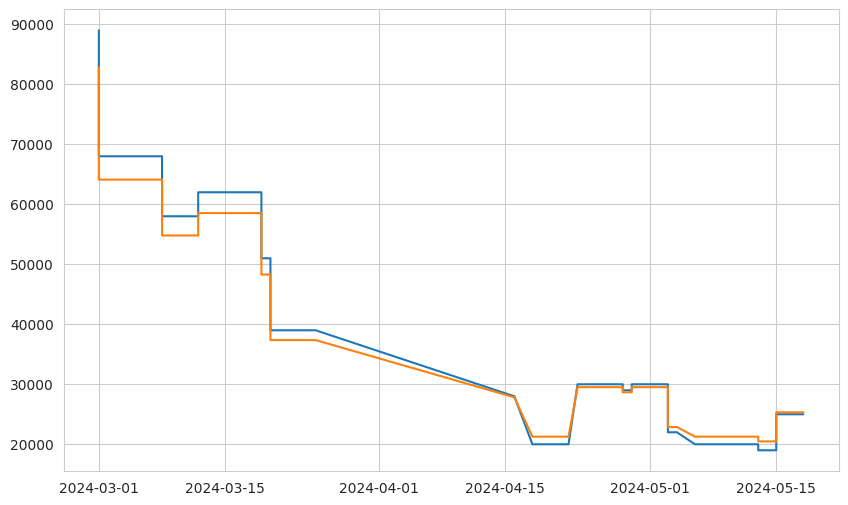

In [58]:
# Plot the results
plot_series(dates_valid, (x_valid_original, predictions))

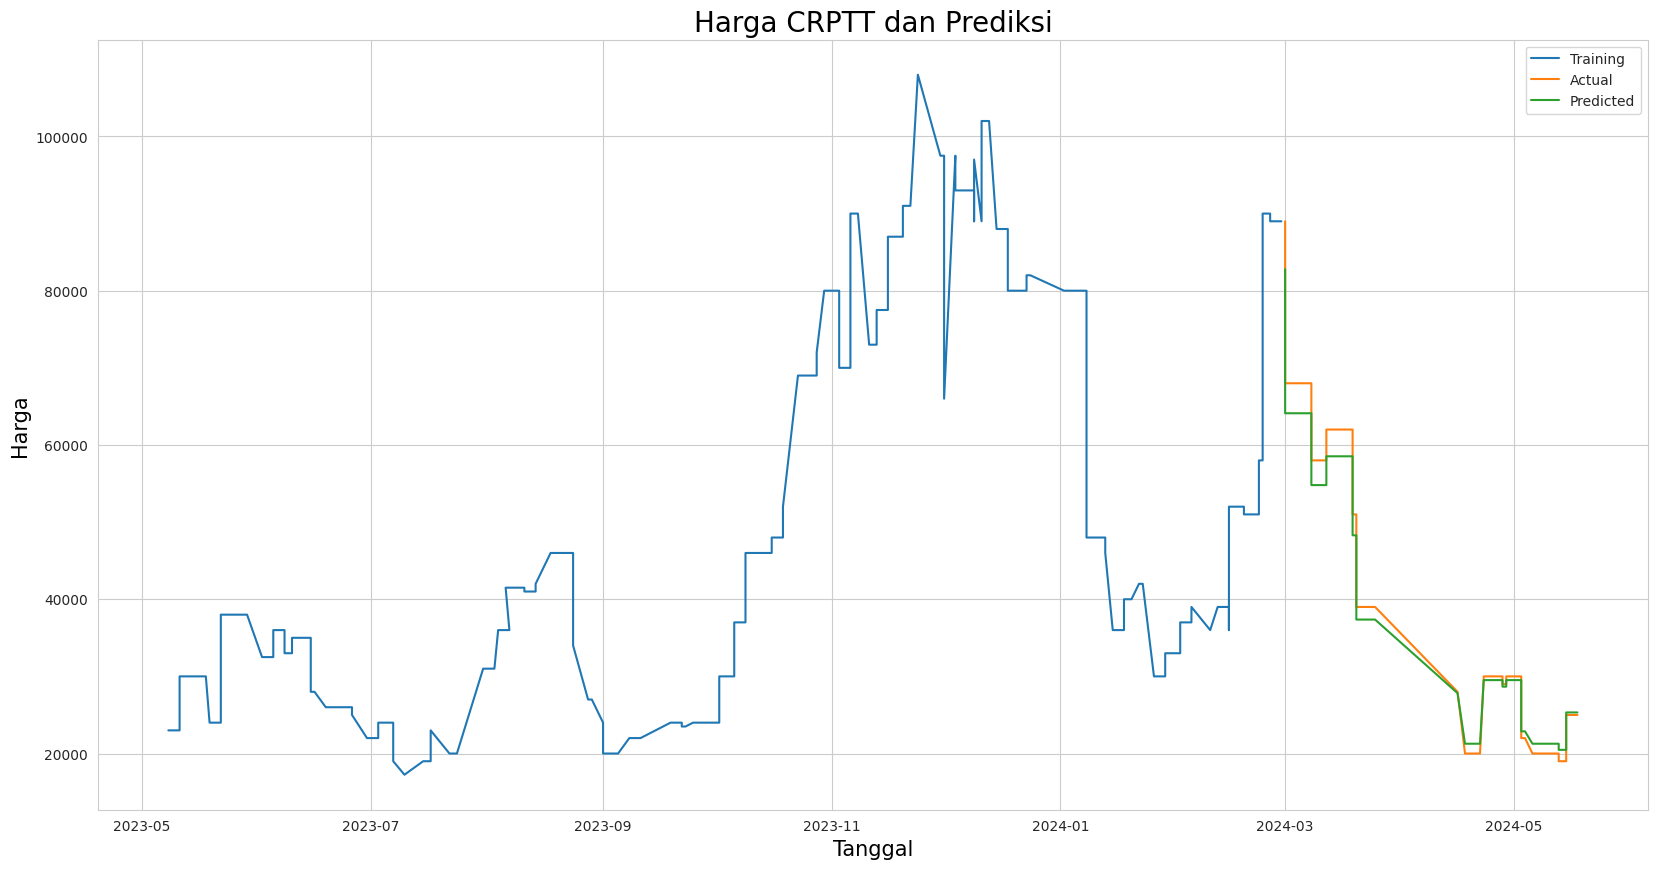

In [59]:
# Plot predicted vs actual values
train = df_copy[:split_time]
test = df_copy[split_time:]

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train.index, train['HARGA'], label='Training')
plt.plot(test.index, test['HARGA'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title("Harga CRPTT dan Prediksi", color='black', fontsize=20)
plt.xlabel('Tanggal', color='black', fontsize=15)
plt.ylabel('Harga', color='black', fontsize=15)
plt.legend()
plt.show()

## Forecasting

In [78]:
# Ambil jendela terakhir dari data validasi sebagai input pertama
last_window = x_valid[-window_size:]
input_data = np.reshape(last_window, (1, window_size, 1))

# Tentukan jumlah langkah waktu ke depan yang ingin Anda prediksi
steps_ahead = 200

# Lakukan peramalan ke depan
forecast = []
for _ in range(steps_ahead):
    # Lakukan prediksi untuk input_data
    prediction = model.predict(input_data)
    # Tambahkan prediksi ke daftar forecast
    forecast.append(prediction[0, 0])
    # Tambahkan prediksi ke input_data untuk langkah waktu berikutnya
    input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inversi normalisasi untuk semua prediksi
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Buat array tanggal untuk langkah waktu ke depan
next_dates = pd.date_range(start=dates_valid[-1], periods=steps_ahead)

1/1 [==============================] - 0s 24ms/step


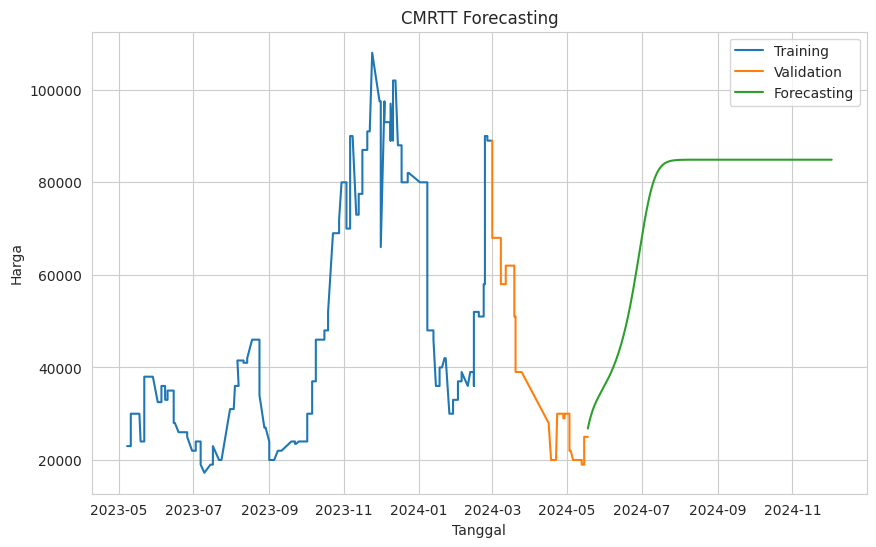

In [81]:
# Plot grafik
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['HARGA'], label='Training')
plt.plot(dates_valid, x_valid_original, label='Validation')
plt.plot(next_dates, forecast, label='Forecasting')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.title('CMRTT Forecasting')
plt.legend()
plt.grid(True)
plt.show()